In [1]:
import sys

import torch_geometric.transforms

sys.path.append('../')

import random
from incidence_graph import IncidenceGraph
import multignn
import torch
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import s2ag
import scipy.stats as stats
import numpy as np


%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'Available memory: {torch.cuda.get_device_properties(device).total_memory / 1024 ** 3 - torch.cuda.memory_allocated(device) / 1024 ** 3:.2f} GB')

Using device: cuda
Available memory: 11.90 GB


In [2]:
random.seed(0)
G = s2ag.generate()
print(f'Graph shape: {G.shape()}')
data = []
for _, val_mask in G:
    data.append(0 if val_mask is None else val_mask)
Y = torch.tensor(data, dtype=torch.float32).view(-1, 1)

Populating graph (papers: 635, authors: 472, queue: 1819): 100%|████████████████████████████████████████████████████████████████████| 10000/10000 [02:57<00:00, 56.20it/s]

Graph shape: [473, 1253, 1860, 2218, 2008, 1332, 623, 194, 36, 3]


In [45]:
random.seed(0)
MAX_DIM_ZEROED = 3
PROPORTION = 0.3
TRAIN_SIZE = 0.6
VAL_SIZE = 0.2

total_size = sum([G.size(i) for i in range(MAX_DIM_ZEROED)])
zero_out = random.sample(list(range(total_size)), int(total_size * PROPORTION))
N = len(zero_out)
X = Y.clone().detach().to(device=device, dtype=torch.float32)
X[zero_out] = 0

train_mask = zero_out[:int(N * TRAIN_SIZE)]
val_mask = zero_out[int(N * TRAIN_SIZE):int(N * (TRAIN_SIZE + VAL_SIZE))]
test_mask = zero_out[int(N * (TRAIN_SIZE + VAL_SIZE)):]

In [29]:
def train(SEED, D, EPOCHS, LOGGING, A_SIZE, LAYERS=1):
    random.seed(SEED)
    torch.random.manual_seed(SEED)
    A = G.sparse_matrices(neighbor_dists=[], rel_dims=range(-1, -A_SIZE, -1))
    for i in range(len(A)):
        A[i] = A[i].to(device=device)
    layers = []
    for i in range(LAYERS):
        in_d = 1 if i == 0 else D
        output_func = nn.Linear(D, 1) if i == LAYERS - 1 else None
        layers.append(multignn.MultiGraphLayer(vertex_agg_func=multignn.sparse_vertex_agg,
                                               graph_agg_func=multignn.LinearGraphAggregate(len(A), in_d, D, activation_func=nn.LeakyReLU(), use_bias=True),
                                               update_func= multignn.LinearMessageUpdate(in_d, D, D, activation_func=nn.LeakyReLU(), use_bias=True),
                                               output_func=output_func))
    model = multignn.PartialForwardNN(*layers).to(device=device)
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = nn.L1Loss()
    #sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

    tr_losses = []
    val_losses = []

    it = range(EPOCHS)
    if LOGGING == 0:
        it = tqdm(it, desc='Training')
    elif LOGGING == 1:
        print('Epoch #: Train Loss, Validation Loss, Validation Accuracy')

    for epoch in it:
        opt.zero_grad()
        output = model.forward(X, A).to(device='cpu')
        loss = loss_func(output[train_mask], Y[train_mask])
        loss.backward()
        opt.step()
        tr_losses.append(loss.item())

        with torch.no_grad():
            output = model.forward(X, A)[val_mask].to(device='cpu')
            val_loss = loss_func(output, Y[val_mask])
            val_losses.append(val_loss.item())
            #sched.step(val_loss)

        if LOGGING == 1:
            print(f'Epoch {epoch + 1:4}\t{loss.item():.8f}\t{val_loss.item():.8f}')

    if LOGGING == 0:
        it.close()

    return model, tr_losses, val_losses, A

In [5]:
def plot(tr_losses, val_losses, start=0, filename=None):
    xs = list(range(start, len(tr_losses)))
    plt.rcParams['figure.figsize'] = (9.0, 6.0)
    plt.plot(xs, tr_losses[start:], label='training loss')
    plt.plot(xs, val_losses[start:], label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss values from epochs {start + 1} to {len(tr_losses)}')
    plt.legend()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [6]:
def test(model, A, threshold=10, logging=1):
    model.eval()
    output = model.forward(X, A).to(device='cpu')
    abs_err = []
    rel_err = []
    for i in test_mask:
        abs_err.append(abs(output[i].item() - Y[i].item()))
        rel_err.append(abs(output[i].item() - Y[i].item()) / Y[i].item() * 100)

    if logging == 1:
        print(f'{len(abs_err)} samples in test set')
        print(f'Mean absolute error: {np.mean(abs_err)}, {np.std(abs_err)}')
        print(f'Median absolute error: {np.median(abs_err)}, {stats.iqr(abs_err)}')
        print(f'Range of absolute error: {min(abs_err)}, {max(abs_err)}')
        print(f'Mean relative error %: {np.mean(rel_err)}, {np.std(rel_err)}')
        print(f'Median relative error %: {np.median(rel_err)}, {stats.iqr(rel_err)}')
        print(f'Range of relative error %: {min(rel_err)}, {max(rel_err)}')

    acc = sum([1 if rel_err[i] < threshold else 0 for i in range(len(rel_err))]) / len(rel_err)*100
    if logging == 1:
        print(f'Accuracy: {acc}')

    return acc, abs_err, rel_err


In [7]:
def hist(data, filename=None):
    plt.rcParams['figure.figsize'] = (9.0, 6.0)
    plt.hist(data, density=True)
    plt.xlabel('Relative error %')
    plt.ylabel('% of samples')
    plt.title('Relative error distribution')
    if filename is not None:
        plt.savefig(filename)
    plt.show()

Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 229.47it/s]


215 samples in test set
Mean absolute error: 245.1380301431168, 2892.0365136320615
Median absolute error: 1.6744213104248047, 9.961092948913574
Range of absolute error: 0.0065460205078125, 42358.2841796875
Mean relative error %: 19.286704359351802, 26.17610685725356
Median relative error %: 4.285392761230469, 27.828007539113365
Range of relative error %: 0.00404075339988426, 99.644653068759
Accuracy: 57.674418604651166


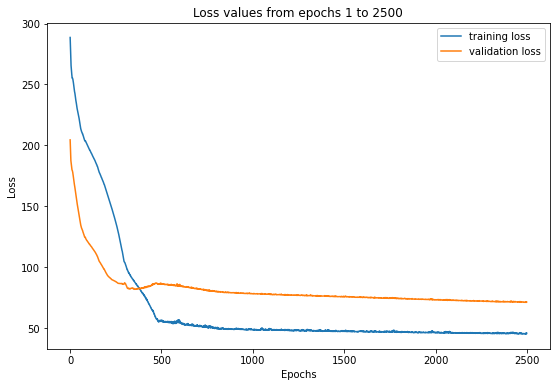

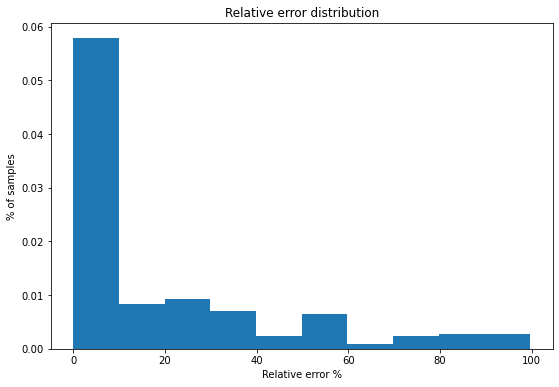

In [46]:
# restriction: # params < input size, D=32, epocs=2500, A=10
model, tr_losses, val_losses, A = train(0, 16, 2500, 0, 10, 1)
_, _, rel = test(model, A)
plot(tr_losses, val_losses)
hist(rel)

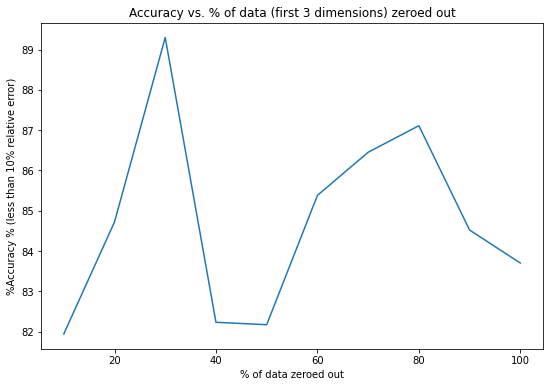

In [46]:
accs = [73.61,61.81 ]
meds = [0.62,2.72 ]
xs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.rcParams['figure.figsize'] = (9.0, 6.0)
plt.plot(xs, accs)
plt.xlabel('% of data zeroed out')
plt.ylabel('%Accuracy % (less than 10% relative error)')
plt.title(f'Accuracy vs. % of data (first 3 dimensions) zeroed out')
plt.show()